[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several fascinating ocean mammals you might want to explore:\n\n1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and complex communication skills.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are smaller, have different shaped fins, and tend to be less social.\n\n3. **Seals**: These pinnipeds are known for their streamlined bodies and are found in various marine environments. There are several species, such as the harbor seal and elephant seal.\n\n4. **Sea Lions**: Unlike seals, sea lions have external ear flaps and are more agile on land, using their flippers to "walk."\n\n5. **Walruses**: Recognizable by their large tusks, walruses are social animals that typically inhabit cold Arctic regions.\n\n6. **Manatees**: Also known as sea cows, manatees are gentle, slow-moving herbivores that frequent warm coastal waters and rivers.\n\n7. **Dugongs**: Similar to manatees

We can run our chat model in a simple graph with `MessagesState`.

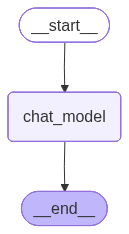

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: These intelligent and social creatures are known for their playful behavior and are found in oceans worldwide.

2. **Porpoises**: Similar to dolphins but generally smaller, porpoises are found in coastal waters and are more elusive.

3. **Seals**: These pinnipeds are adapted to both marine and terrestrial environments, with species like the harbor seal and elephant seal.

4. **Sea Lions**: Larger and more social than seals, sea lions are known for their external ear flaps and ability to "walk" on land u

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

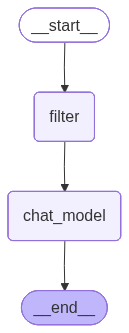

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might find interesting to learn about:

1. **Dolphins**: These highly intelligent and social creatures are known for their playful behavior and complex communication. Species include the bottlenose dolphin and the orca, which is technically the largest member of the dolphin family.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and stouter, with different teeth and dorsal fin shapes. The harbor porpoise is one of the more well-known species.

3. **Seals**: These pinnipeds are divided into earless or true seals and eared se

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

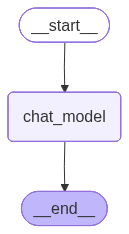

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might find interesting to learn about:

1. **Dolphins**: These highly intelligent and social creatures are known for their playful behavior and complex communication. Species include the bottlenose dolphin and the orca, which is technically the largest member of the dolphin family.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and 

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals besides whales that you might find interesting to learn about:

1. **Dolphins**: These highly intelligent and social creatures are known for their playful behavior and complex communication. Species include the bottlenose dolphin and the orca, which is technically the largest member of the dolphin family.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and 

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

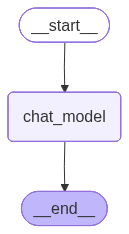

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

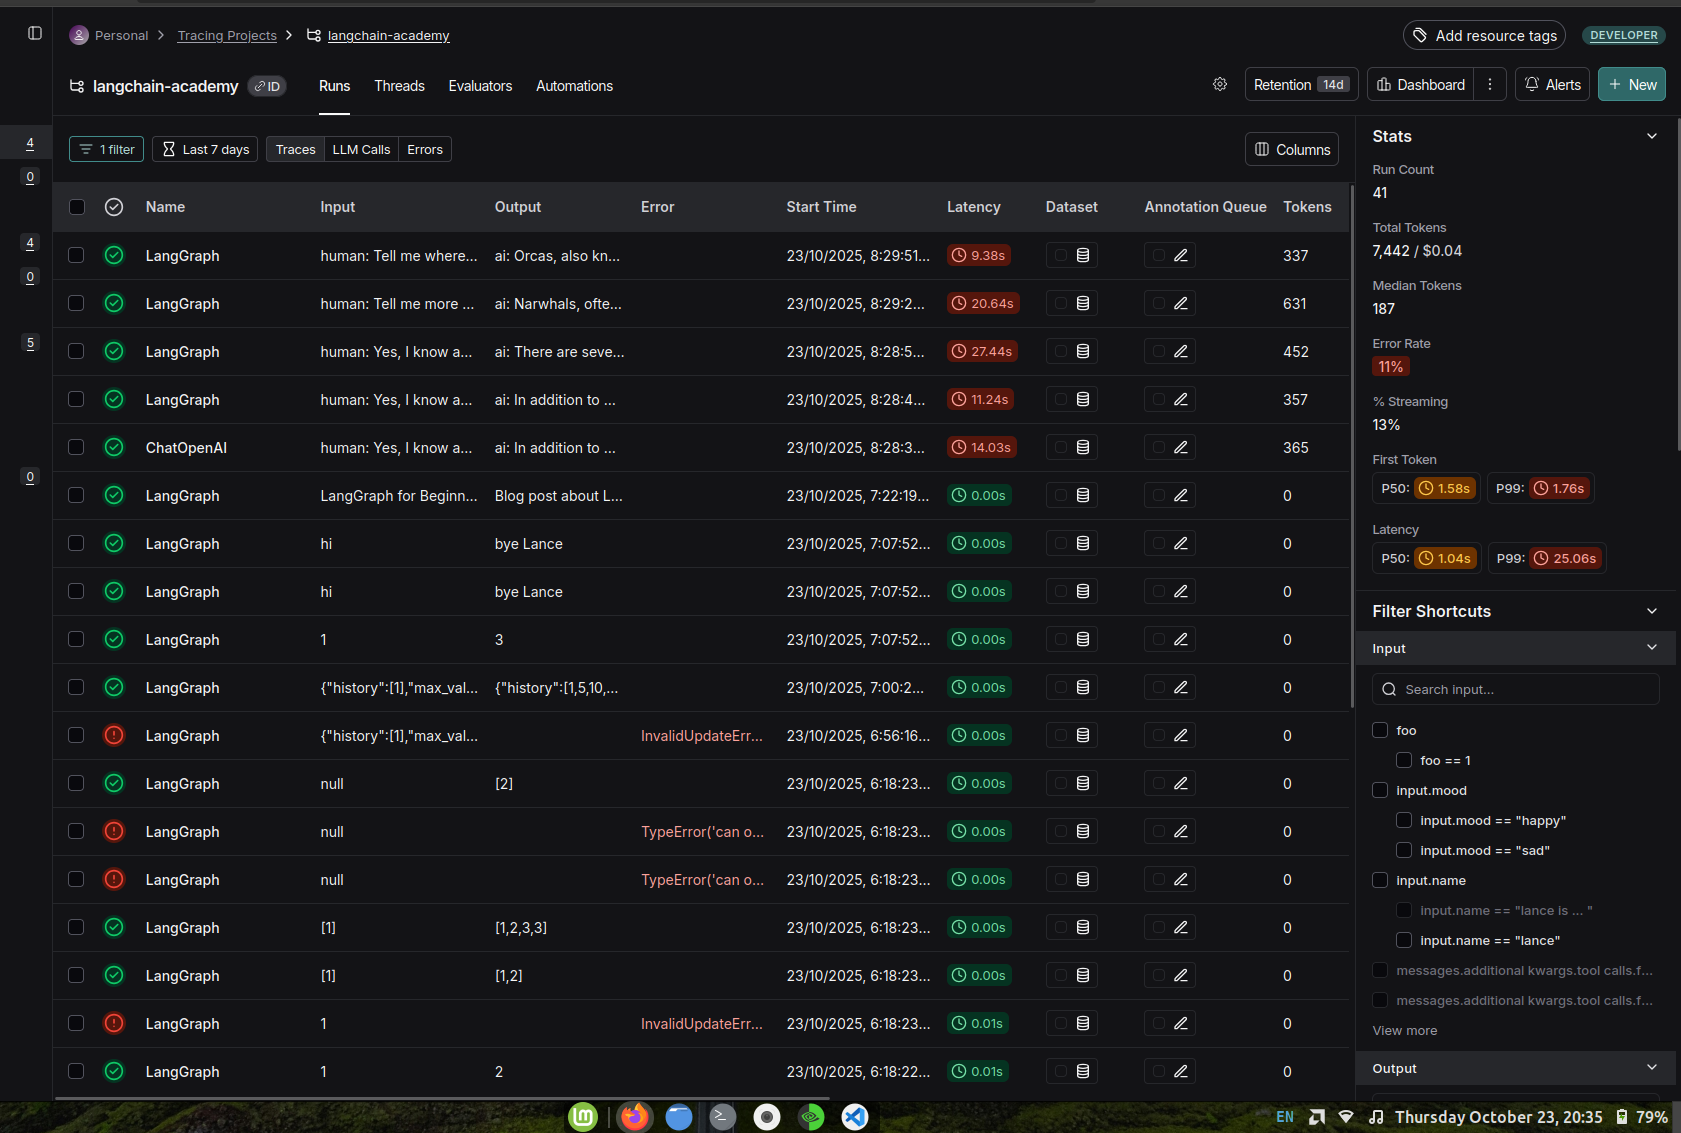

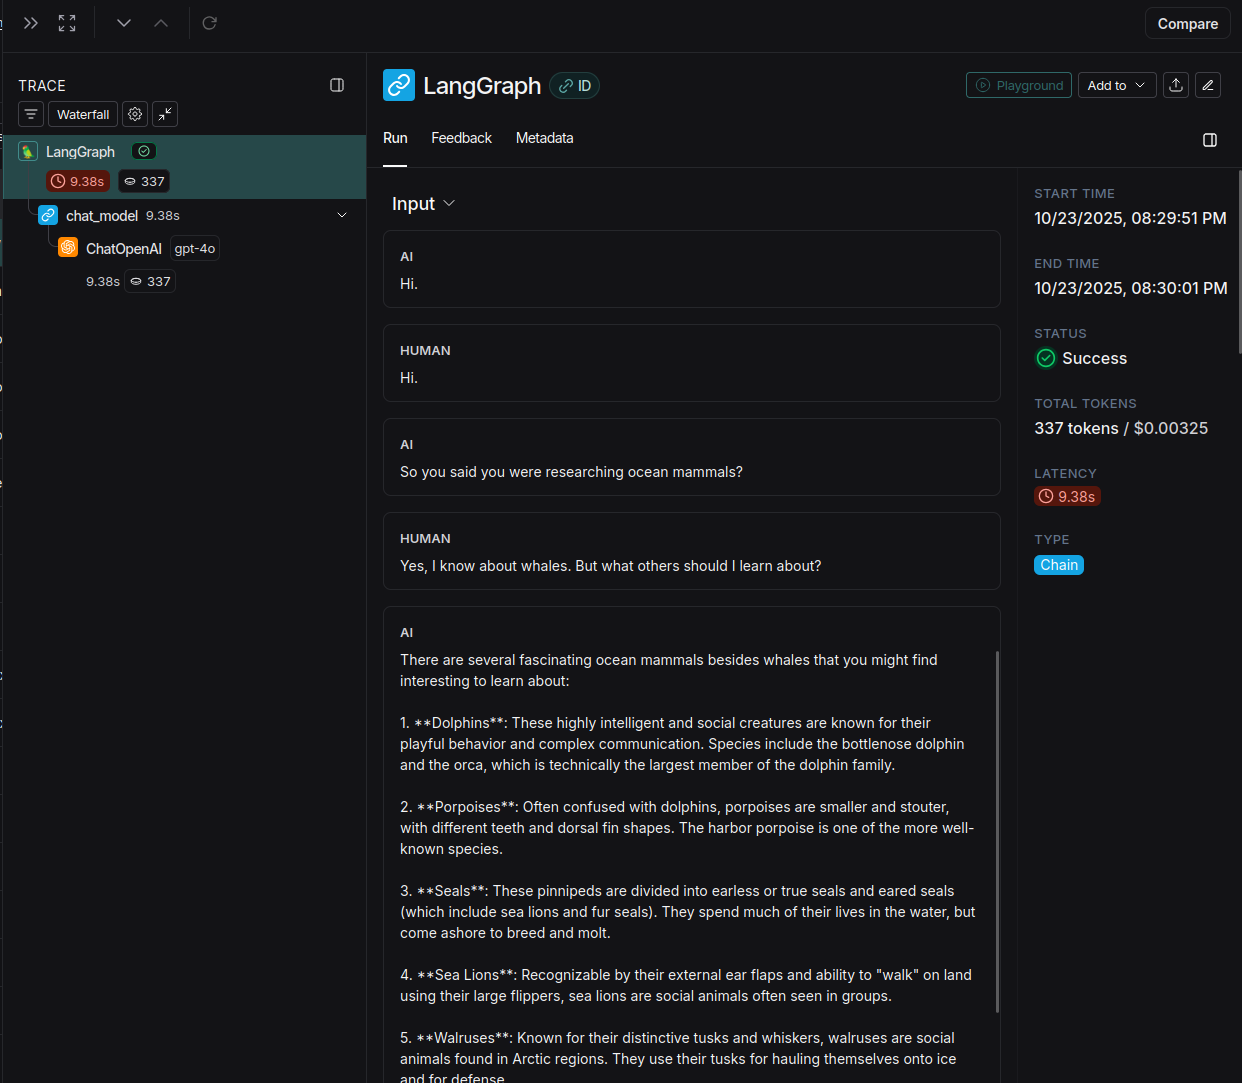

# some tinkering

In [18]:
# Customer Support Bot with Message Management

from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage, trim_messages
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-4o")

# Approach 1: Using RemoveMessage to clean state
def filter_old_messages(state: MessagesState):
    """Keep only last 4 messages in state"""
    if len(state["messages"]) > 4:
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-4]]
        return {"messages": delete_messages}
    return {}

# Approach 2: Filter messages before model invocation
def support_with_filter(state: MessagesState):
    """Use only last 3 messages for context"""
    print(f"Total messages in state: {len(state['messages'])}")
    recent_messages = state["messages"][-3:]
    print(f"Sending to model: {len(recent_messages)} messages")
    return {"messages": [llm.invoke(recent_messages)]}

# Approach 3: Trim messages by token count
def support_with_trim(state: MessagesState):
    """Trim to max 150 tokens"""
    print(f"Total messages in state: {len(state['messages'])}")
    trimmed = trim_messages(
        state["messages"],
        max_tokens=150,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o"),
        allow_partial=False
    )
    print(f"After trimming: {len(trimmed)} messages")
    return {"messages": [llm.invoke(trimmed)]}

# Build graph with all three approaches
print("=== Approach 1: RemoveMessage (modifies state) ===")
builder1 = StateGraph(MessagesState)
builder1.add_node("filter", filter_old_messages)
builder1.add_node("support", lambda state: {"messages": [llm.invoke(state["messages"])]})
builder1.add_edge(START, "filter")
builder1.add_edge("filter", "support")
builder1.add_edge("support", END)
graph1 = builder1.compile()

print("\n=== Approach 2: Message Filtering (state unchanged) ===")
builder2 = StateGraph(MessagesState)
builder2.add_node("support", support_with_filter)
builder2.add_edge(START, "support")
builder2.add_edge("support", END)
graph2 = builder2.compile()

print("\n=== Approach 3: Token Trimming (state unchanged) ===")
builder3 = StateGraph(MessagesState)
builder3.add_node("support", support_with_trim)
builder3.add_edge(START, "support")
builder3.add_edge("support", END)
graph3 = builder3.compile()

# Test with a long conversation
messages = [
    HumanMessage("Hi, I have a problem with my order", name="Customer", id="1"),
    AIMessage("Hello! I'd be happy to help. What's your order number?", name="Bot", id="2"),
    HumanMessage("Order #12345", name="Customer", id="3"),
    AIMessage("Let me look that up for you.", name="Bot", id="4"),
    HumanMessage("It hasn't arrived yet", name="Customer", id="5"),
    AIMessage("I see. When was it supposed to arrive?", name="Bot", id="6"),
    HumanMessage("Last Monday", name="Customer", id="7"),
]

print("\n=== Testing Approach 1: RemoveMessage ===")
result1 = graph1.invoke({"messages": messages})
print(f"Messages in final state: {len(result1['messages'])}")

print("\n=== Testing Approach 2: Filtering ===")
result2 = graph2.invoke({"messages": messages})
print(f"Messages in final state: {len(result2['messages'])}")

print("\n=== Testing Approach 3: Trimming ===")
result3 = graph3.invoke({"messages": messages})
print(f"Messages in final state: {len(result3['messages'])}")

print("\n=== Key Observations ===")
print("✓ RemoveMessage: State actually gets cleaned (fewer messages)")
print("✓ Filtering: State unchanged, but model sees filtered view")
print("✓ Trimming: State unchanged, model sees token-limited view")
print("✓ Use RemoveMessage when state management matters")
print("✓ Use filtering/trimming for simple context limiting")

=== Approach 1: RemoveMessage (modifies state) ===

=== Approach 2: Message Filtering (state unchanged) ===

=== Approach 3: Token Trimming (state unchanged) ===

=== Testing Approach 1: RemoveMessage ===
Messages in final state: 5

=== Testing Approach 2: Filtering ===
Total messages in state: 7
Sending to model: 3 messages
Messages in final state: 8

=== Testing Approach 3: Trimming ===
Total messages in state: 7
After trimming: 7 messages
Messages in final state: 8

=== Key Observations ===
✓ RemoveMessage: State actually gets cleaned (fewer messages)
✓ Filtering: State unchanged, but model sees filtered view
✓ Trimming: State unchanged, model sees token-limited view
✓ Use RemoveMessage when state management matters
✓ Use filtering/trimming for simple context limiting
